<a href="https://colab.research.google.com/github/lucabem/CompeticionMineria/blob/main/callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sección nueva

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [3]:
!rm -rf /root/.keras/datasets/*

In [4]:
dataset_url = 'https://github.com/lucabem/CompeticionMineria/blob/main/data/dataset_images.zip?raw=true'
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='train_data', 
                                   extract=True)

78069760/78067648 [==============================] - 1s 0us/step


In [5]:
!rm -rf /root/.keras/datasets/train_data.tar.gz /root/.keras/datasets/train_data
!ls -l /root/.keras/datasets/

total 24
drwxr-xr-x 27 root root  4096 Mar 21 10:29 ImagesTrain
drwxr-xr-x  2 root root 20480 Mar 21 10:29 Test


In [6]:
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2500


In [7]:
test_path = pathlib.Path('/root/.keras/datasets/Test')
images_test = os.listdir(test_path)
print(len(images_test))

500


In [8]:
for direct in train_path.iterdir():
  if direct.is_dir():
    direct.rename(train_path / direct.name.split(sep='_100')[0])

In [9]:
img_height = 224
img_width  = 224

In [10]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 6.8MB/s 


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
import tensorflow_addons as tfa

In [13]:
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K  
import tensorflow as tf
keras = tf.keras

### Data Augmentation

In [14]:
batch_size = 32
img_height = 224
img_width  = 224
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')

In [15]:
import shutil
import os 

In [16]:
train_ds_gen = ImageDataGenerator(vertical_flip    = True,
                                  horizontal_flip  = True,
                                  validation_split = 0.2)

In [17]:
train_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='training',
                                                  class_mode='categorical')

Found 2000 images belonging to 25 classes.


In [18]:
valid_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical')

Found 500 images belonging to 25 classes.


In [19]:
test_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  class_mode='categorical')

Found 2500 images belonging to 25 classes.


### Modelos

#### Funcion para predecir

In [20]:
img_height = 224
img_width  = 224
test_path  = pathlib.Path('/root/.keras/datasets/Test')

In [21]:
# predicting images
from keras.preprocessing import image
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

def make_predictions(model_final,
                     path_test ='/root/.keras/datasets/Test',
                     name_file_submission = 'submission.csv'):

  images_test = os.listdir(path_test)
  samples_to_predict = []

  for img in images_test:
    path_img = os.path.join(path_test, img)
    img = image.load_img(path_img,
                        target_size=(img_width, img_height))
    x = image.img_to_array(img)
    samples_to_predict.append(x)

  samples_to_predict  = np.array(samples_to_predict)
  predictions = model_final.predict(samples_to_predict)
  classes = np.argmax(predictions, axis = 1)

  data = {'id.jpg': images_test, 'label': classes}
  data = pd.DataFrame(data)
  data.to_csv(name_file_submission, index = False)

  return data

# Modificaciones

In [ ]:
from keras.layers.normalization import BatchNormalization


In [ ]:
batch_size = 68
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

conv_1024 = Conv2D(1024, (3,3), activation='relu')
conv_512  = Conv2D(512, (3,3), activation='relu')

flattern  = Flatten()
batch_normal = BatchNormalization()
dropout   = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_22 = tf.keras.Sequential([
  base_model,
  conv_1024,
  conv_512,
  flattern,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])

In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_22.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_22 = model_22.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 508s 8s/step - loss: 2.9746 - accuracy: 0.1661 - f1_score: 0.1462 - val_loss: 1.5037 - val_accuracy: 0.6295 - val_f1_score: 0.5928
Epoch 2/50
63/63 [==============================] - 499s 8s/step - loss: 1.6180 - accuracy: 0.5325 - f1_score: 0.5221 - val_loss: 0.9249 - val_accuracy: 0.7321 - val_f1_score: 0.7271
Epoch 3/50
63/63 [==============================] - 497s 8s/step - loss: 1.0793 - accuracy: 0.6767 - f1_score: 0.6740 - val_loss: 0.9085 - val_accuracy: 0.7366 - val_f1_score: 0.7339
Epoch 4/50
63/63 [==============================] - 498s 8s/step - loss: 0.8001 - accuracy: 0.7627 - f1_score: 0.7626 - val_loss: 0.6996 - val_accuracy: 0.7991 - val_f1_score: 0.7967
Epoch 5/50
63/63 [==============================] - 496s 8s/step - loss: 0.7014 - accuracy: 0.7704 - f1_score: 0.7700 - val_loss: 0.5700 - val_accuracy: 0.8482 - val_f1_score: 0.8477
Epoch 6/50
63/63 [==============================] - 494s 8s/step - loss: 0.5703 - acc

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

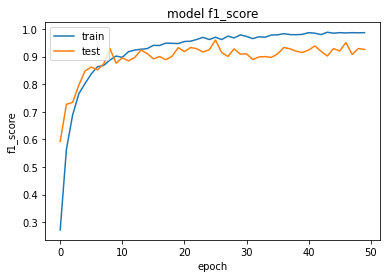

In [ ]:
plt.plot(model_history_22.history['f1_score'])
plt.plot(model_history_22.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
make_predictions(model_22, name_file_submission='modelo_mejorado2_2048_512_1024_256_128_52.csv')

,id.jpg,label
0,Grassland__10.jpg,17
1,Open_Shrub_9.jpg,21
2,Forest_CEN_12.jpg,16
3,Forest_CEN_15.jpg,8
4,Forest_OEB_7.jpg,15
...,...,...
495,Forest_CDB_7.jpg,11
496,Open_Shrub_11.jpg,21
497,Close_Shru_0.jpg,2
498,Cropland_s_0.jpg,4


In [ ]:
files.download("modelo_mejorado2_2048_512_1024_256_128_52.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_22.save('modelo_mejorado2_2048_512_1024_256_128_52')

INFO:tensorflow:Assets written to: modelo_mejorado2_2048_512_1024_256_128_52/assets


In [ ]:
! zip -r modelo_mejorado2_2048_512_1024_256_128_52.zip modelo_mejorado2_2048_512_1024_256_128_52

	zip warning: name not matched: modelo_mejorado2_2048_512_1024_256_128_52

zip error: Nothing to do! (try: zip -r modelo_mejorado2_2048_512_1024_256_128_52.zip . -i modelo_mejorado2_2048_512_1024_256_128_52)


In [ ]:
files.download("modelo_mejorado2_2048_512_1024_256_128_52.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
!pip install --upgrade tensorflow_hub
!pip install --upgrade tensorflow_addons

import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.preprocessing import image
import numpy as np
import pandas as pd
from google.colab import files
import tensorflow_addons as tfa
import pathlib

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.7/dist-packages (0.11.0)
Requirement already up-to-date: tensorflow_addons in /usr/local/lib/python3.7/dist-packages (0.12.1)


In [22]:
from google.colab import files
uploaded=files.upload()

Saving modelo_mejorado2_2048_512_1024_256_128_52.zip to modelo_mejorado2_2048_512_1024_256_128_52.zip


In [23]:
!unzip "modelo_mejorado2_2048_512_1024_256_128_52.zip"

Archive:  modelo_mejorado2_2048_512_1024_256_128_52.zip
   creating: modelo_mejorado2_2048_512_1024_256_128_52/
   creating: modelo_mejorado2_2048_512_1024_256_128_52/assets/
   creating: modelo_mejorado2_2048_512_1024_256_128_52/variables/
  inflating: modelo_mejorado2_2048_512_1024_256_128_52/variables/variables.data-00000-of-00001  
  inflating: modelo_mejorado2_2048_512_1024_256_128_52/variables/variables.index  
  inflating: modelo_mejorado2_2048_512_1024_256_128_52/saved_model.pb  


In [24]:
ls modelo_mejorado2_2048_512_1024_256_128_52/


assets/  saved_model.pb  variables/


In [25]:
path_to_model = "modelo_mejorado2_2048_512_1024_256_128_52/"
model = tf.keras.models.load_model(path_to_model, compile=True, custom_objects={'f1':tfa.metrics.F1Score(num_classes=25, average='weighted')})

In [ ]:
model.summary()

NameError: ignored

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

checkpointer = ModelCheckpoint("resnet50" +
                               "_ms_transfer_final." +
                               "{epoch:02d}-{val_f1_score:.3f}" +
                               ".hdf5",
                               monitor='val_f1_score',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

earlystopper = EarlyStopping(monitor='val_f1_score',
                             patience=10,
                             mode='max')

In [25]:
opt = tf.keras.optimizers.Adagrad()
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)
batch_size = 68
model_history = model.fit(  
    train_data_gen,
    epochs=70,
    initial_epoch = 50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size,
    callbacks=[checkpointer, earlystopper])

Epoch 51/70
63/63 [==============================] - 1790s 28s/step - loss: 1.4564 - accuracy: 0.5659 - f1_score: 0.5622 - val_loss: 2.4387 - val_accuracy: 0.5268 - val_f1_score: 0.4792

Epoch 00051: val_f1_score improved from -inf to 0.47919, saving model to resnet50_ms_transfer_final.51-0.479.hdf5
Epoch 52/70
63/63 [==============================] - 1804s 29s/step - loss: 0.4593 - accuracy: 0.8588 - f1_score: 0.8588 - val_loss: 1.7566 - val_accuracy: 0.5938 - val_f1_score: 0.5827

Epoch 00052: val_f1_score improved from 0.47919 to 0.58273, saving model to resnet50_ms_transfer_final.52-0.583.hdf5
Epoch 53/70
63/63 [==============================] - 1789s 28s/step - loss: 0.2313 - accuracy: 0.9283 - f1_score: 0.9281 - val_loss: 1.7505 - val_accuracy: 0.6384 - val_f1_score: 0.6391

Epoch 00053: val_f1_score improved from 0.58273 to 0.63907, saving model to resnet50_ms_transfer_final.53-0.639.hdf5
Epoch 54/70
63/63 [==============================] - 1814s 29s/step - loss: 0.1858 - accura

In [ ]:
from google.colab import files
files.download("resnet50_ms_transfer_final.61-0.96002.hdf5")

In [22]:
from keras.models import load_model
model = load_model('/content/resnet50_ms_transfer_final.58-0.968.hdf5',custom_objects={'f1':tfa.metrics.F1Score(num_classes=25, average='weighted')})

In [22]:
make_predictions(model, name_file_submission='modelo_mejorado3.csv')

,id.jpg,label
0,Forest_CDN_11.jpg,6
1,Marshland__9.jpg,19
2,Forest_DDB_5.jpg,7
3,Forest_DEN_7.jpg,12
4,Forest_ODN_11.jpg,14
...,...,...
495,Cereal_Cro_5.jpg,1
496,Swamp_add__2.jpg,23
497,Moss_and_L_14.jpg,20
498,Moss_and_L_18.jpg,20


In [23]:
files.download("modelo_mejorado3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
tf.random.set_seed(2021)
batch_size = 68
model_history = model.fit(  
    train_data_gen,
    epochs=70,
    initial_epoch = 58,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size,
    callbacks=[checkpointer, earlystopper])

Epoch 59/70
63/63 [==============================] - 1729s 27s/step - loss: 0.0834 - accuracy: 0.9706 - f1_score: 0.9704 - val_loss: 1.2554 - val_accuracy: 0.6830 - val_f1_score: 0.6793

Epoch 00059: val_f1_score improved from -inf to 0.67928, saving model to resnet50_ms_transfer_final.59-0.679.hdf5
Epoch 60/70
63/63 [==============================] - 1722s 27s/step - loss: 0.0637 - accuracy: 0.9835 - f1_score: 0.9834 - val_loss: 0.6292 - val_accuracy: 0.8259 - val_f1_score: 0.8238

Epoch 00060: val_f1_score improved from 0.67928 to 0.82378, saving model to resnet50_ms_transfer_final.60-0.824.hdf5
Epoch 61/70
63/63 [==============================] - 1718s 27s/step - loss: 0.0964 - accuracy: 0.9694 - f1_score: 0.9694 - val_loss: 0.3723 - val_accuracy: 0.9107 - val_f1_score: 0.9098

Epoch 00061: val_f1_score improved from 0.82378 to 0.90975, saving model to resnet50_ms_transfer_final.61-0.910.hdf5
Epoch 62/70
63/63 [==============================] - 1723s 27s/step - loss: 0.1422 - accura

In [28]:
from keras.models import load_model
model = load_model('/content/resnet50_ms_transfer_final.70-0.950.hdf5',custom_objects={'f1':tfa.metrics.F1Score(num_classes=25, average='weighted')})

In [29]:
make_predictions(model, name_file_submission='modelo_mejorado4.csv')

,id.jpg,label
0,Forest_CDN_11.jpg,6
1,Marshland__9.jpg,19
2,Forest_DDB_5.jpg,9
3,Forest_DEN_7.jpg,12
4,Forest_ODN_11.jpg,14
...,...,...
495,Cereal_Cro_5.jpg,1
496,Swamp_add__2.jpg,23
497,Moss_and_L_14.jpg,20
498,Moss_and_L_18.jpg,20


In [30]:
files.download("modelo_mejorado4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>